Data loaded. Shape: (12316, 32)
Generating plots...


C:\Users\DELL\AppData\Local\Temp\ipykernel_4316\2571671945.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour


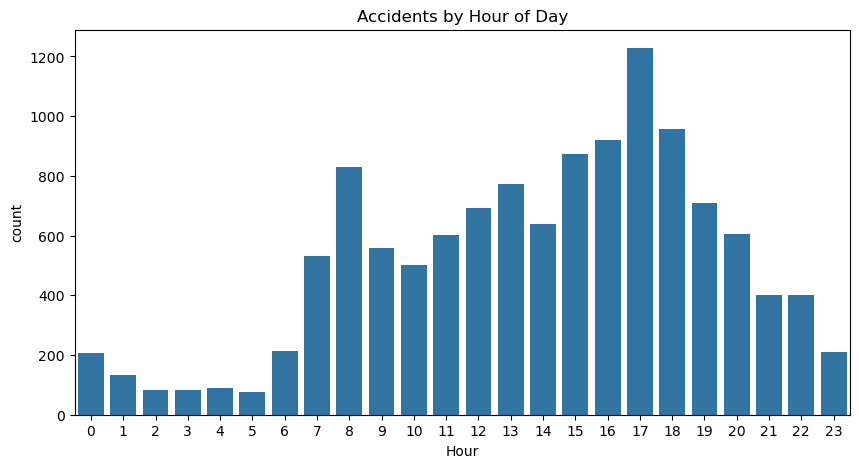

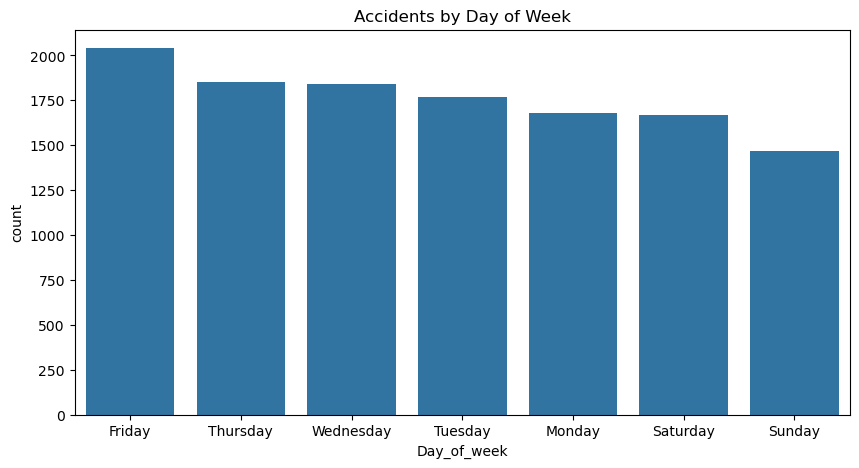

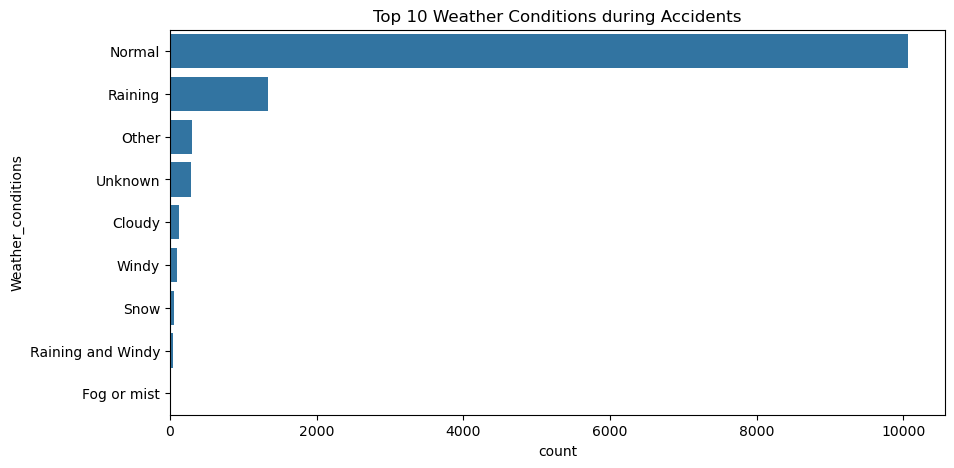

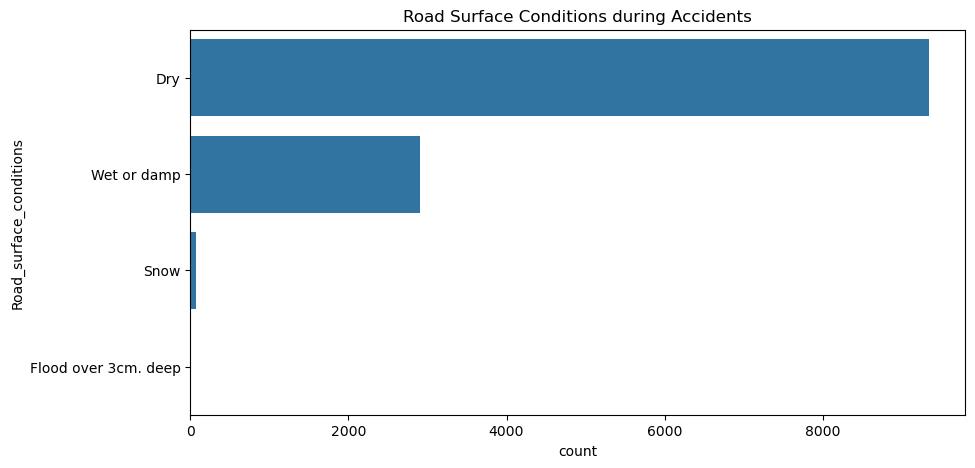

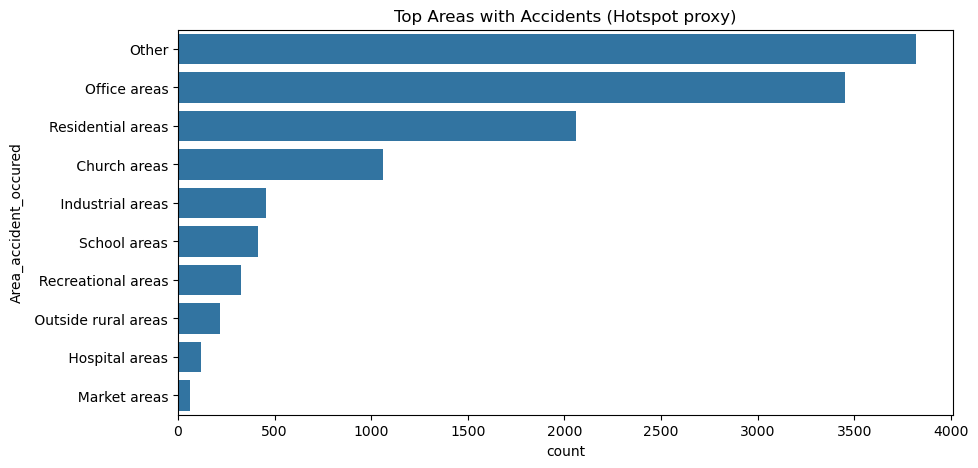


Classification report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      2084
           1       0.15      0.11      0.13       380

    accuracy                           0.77      2464
   macro avg       0.50      0.50      0.50      2464
weighted avg       0.74      0.77      0.75      2464

Confusion matrix:
 [[1848  236]
 [ 338   42]]
ROC AUC: 0.5302530558642287


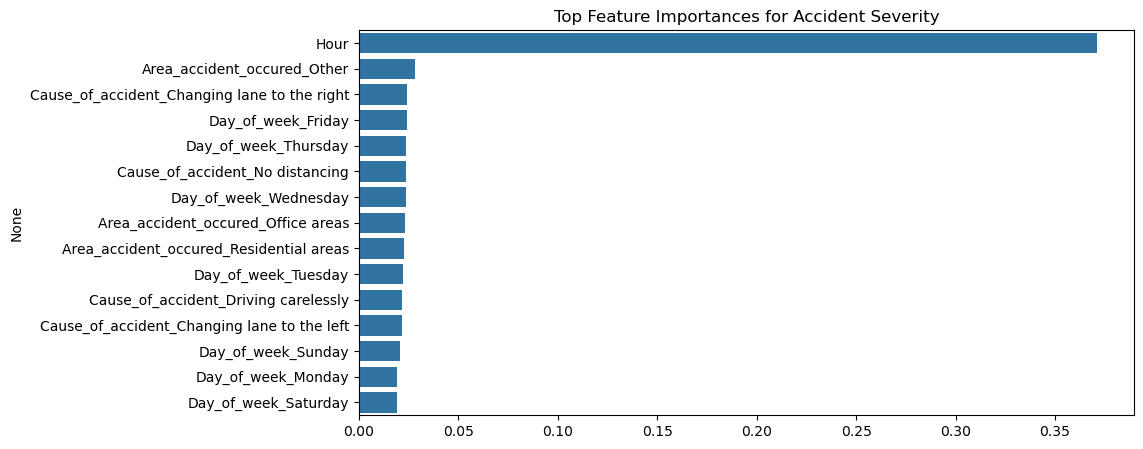

Top feature importances:
 Hour                                            0.371075
Area_accident_occured_Other                     0.028062
Cause_of_accident_Changing lane to the right    0.024207
Day_of_week_Friday                              0.024187
Day_of_week_Thursday                            0.023788
Cause_of_accident_No distancing                 0.023772
Day_of_week_Wednesday                           0.023657
Area_accident_occured_Office areas              0.023055
Area_accident_occured_Residential areas         0.022907
Day_of_week_Tuesday                             0.022057
Cause_of_accident_Driving carelessly            0.021678
Cause_of_accident_Changing lane to the left     0.021494
Day_of_week_Sunday                              0.020844
Day_of_week_Monday                              0.019380
Day_of_week_Saturday                            0.019323
dtype: float64


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import sklearn

# -------------------------------
# Utility functions
# -------------------------------
def preprocess_time(df):
    """Extract hour from Time column if available."""
    if 'Time' in df.columns:
        df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour
    else:
        df['Hour'] = np.nan
    return df

def make_target(df):
    """Make binary target: 1 if Serious Injury or Fatal Injury, else 0."""
    if 'Accident_severity' in df.columns:
        df['Severity_binary'] = df['Accident_severity'].isin([
            'Serious Injury','Fatal injury','Fatal Injury'
        ]).astype(int)
    else:
        df['Severity_binary'] = np.nan
    return df

# -------------------------------
# Main analysis
# -------------------------------
def main(path, save_plots=False):
    # Load data
    df = pd.read_csv(path)
    print("Data loaded. Shape:", df.shape)

    # Preprocess
    df = preprocess_time(df)
    df = make_target(df)

    # -------------------------------
    # Exploratory Data Analysis
    # -------------------------------
    print("Generating plots...")
    plt.figure(figsize=(10,5))
    sns.countplot(x='Hour', data=df)
    plt.title('Accidents by Hour of Day')
    if save_plots: plt.savefig('accidents_by_hour.png')
    plt.show()

    if 'Day_of_week' in df.columns:
        plt.figure(figsize=(10,5))
        sns.countplot(x='Day_of_week', data=df, order=df['Day_of_week'].value_counts().index)
        plt.title('Accidents by Day of Week')
        if save_plots: plt.savefig('accidents_by_day.png')
        plt.show()

    if 'Weather_conditions' in df.columns:
        plt.figure(figsize=(10,5))
        sns.countplot(y='Weather_conditions', data=df, order=df['Weather_conditions'].value_counts().index[:10])
        plt.title('Top 10 Weather Conditions during Accidents')
        if save_plots: plt.savefig('accidents_by_weather.png')
        plt.show()

    if 'Road_surface_conditions' in df.columns:
        plt.figure(figsize=(10,5))
        sns.countplot(y='Road_surface_conditions', data=df, order=df['Road_surface_conditions'].value_counts().index)
        plt.title('Road Surface Conditions during Accidents')
        if save_plots: plt.savefig('accidents_by_surface.png')
        plt.show()

    if 'Area_accident_occured' in df.columns:
        plt.figure(figsize=(10,5))
        sns.countplot(y='Area_accident_occured', data=df, order=df['Area_accident_occured'].value_counts().index[:10])
        plt.title('Top Areas with Accidents (Hotspot proxy)')
        if save_plots: plt.savefig('accidents_by_area.png')
        plt.show()

    # -------------------------------
    # Modeling
    # -------------------------------
    model_cols = ['Weather_conditions','Road_surface_conditions','Light_conditions',
                  'Day_of_week','Area_accident_occured','Cause_of_accident','Hour']
    model_df = df.dropna(subset=['Severity_binary'])
    model_df = model_df.dropna(subset=['Hour'])

    # Separate categorical and numeric features
    cat_features = [c for c in model_cols if c in model_df.columns and model_df[c].dtype == 'object']
    num_features = ['Hour'] if 'Hour' in model_df.columns else []

    # Backward compatible OneHotEncoder params
    ohe_params = dict(handle_unknown='ignore')
    if sklearn.__version__ >= "1.2":
        ohe_params['sparse_output'] = False
    else:
        ohe_params['sparse'] = False

    ohe = OneHotEncoder(**ohe_params)
    if cat_features:
        X_cat = ohe.fit_transform(model_df[cat_features])
    else:
        X_cat = np.empty((len(model_df),0))

    X_num = model_df[num_features].values if num_features else np.empty((len(model_df),0))
    X = np.hstack([X_cat, X_num])
    y = model_df['Severity_binary'].values

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

    # Train
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]

    # Metrics
    print("\nClassification report:\n", classification_report(y_test,y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test,y_pred))
    print("ROC AUC:", roc_auc_score(y_test,y_prob))

    # Feature importances
    feature_names = list(ohe.get_feature_names_out(cat_features)) + num_features
    feat_imp = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)[:15]

    plt.figure(figsize=(10,5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title('Top Feature Importances for Accident Severity')
    if save_plots: plt.savefig('feature_importances.png')
    plt.show()

    print("Top feature importances:\n", feat_imp)

# -------------------------------
# Run
# -------------------------------
if __name__ == "__main__":
    main(path=r"C:\\Users\\DELL\\OneDrive\\Documents\\Excel files\\RTA Dataset.csv", save_plots=False)
